# Dataset

In [5]:
from pathlib import Path

def ls(path: Path): 
    "Return files on Path, sorted"
    return sorted(list(path.iterdir()))

In [6]:
!pip install -q wandb tqdm matplotlib fastprogress torchmetrics diffusers denoising_diffusion_pytorch fastcore

In [7]:
import wandb
wandb.login(key='6b22cbf359c5924f4500afc1ae572d6827998186', relogin=True, force=True)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [8]:
from pathlib import Path

import numpy as np
import torch
import torchvision.transforms as T
import wandb
from tqdm import tqdm as progress_bar
import cv2

# from cloud_diffusion.utils import ls

PROJECT_NAME = "cloud_diffusion"
DATASET_ARTIFACT = 'ai-industry/cloud_diffusion/SEVIR:v0'

class DummyNextFrameDataset:
    "Dataset that returns random images"
    def __init__(self, num_frames=4, img_size=64, N=1000):
        self.img_size = img_size
        self.num_frames = num_frames
        self.N = N

    def __getitem__(self, idx):
        return torch.randn(self.num_frames, self.img_size, self.img_size)
    
    def __len__(self):
        return self.N


class CloudDataset:
    """Dataset for cloud images
    It loads numpy files from wandb artifact and stacks them into a single array
    It also applies some transformations to the images
    """
    def __init__(self, 
                 files, # list of numpy files to load (they come from the artifact)
                 num_frames=4, # how many consecutive frames to stack
                 scale=True, # if we images to interval [-0.5, 0.5]
                 img_size=64, # resize dim, original images are big (446, 780)
                 valid=False, # if True, transforms are deterministic
                ):

        tfms = [T.RandomCrop(img_size)] if not valid else [T.CenterCrop(img_size)]
        self.tfms = T.Compose(tfms)
        self.load_data(files, num_frames, scale)
        
    def _scale(self, arr):
        "Scales values of array in [0,1]"
        m, M = arr.min(), arr.max()
        return (arr - m) / (M - m)

    def _resize(self, arr, img_size):
        num_events, num_frames = arr.shape[0], arr.shape[3]
        resized_array = np.empty((num_events, img_size, img_size, num_frames))
        for event in range(num_events):
            resized_array[event] = cv2.resize(arr[event], (img_size, img_size))
        return resized_array.transpose((0, 3, 1, 2))
    
    def load_channel(self, file, scale=True):
        one_channel = np.load(file)
        one_channel = one_channel.astype('float32')
        if scale:
            one_day = 0.5 - self._scale(one_channel)
        return one_channel

    def create_windows(self, data, num_frames):
        windows = []
        for event in data:
            wds = np.lib.stride_tricks.sliding_window_view(
                        event,
                        num_frames,
                        axis=0)[::num_frames].transpose(0,4,1,2,3) # (windows, frames, channels, height, width)
            windows.append(wds)
        windows = np.array(windows)
        shape = windows.shape
        windows = windows.reshape(shape[0] * shape[1], shape[2], shape[3], shape[4], shape[5])
        return windows # (batch, channels, frames, height, width)

    def load_data(self, files, num_frames, scale, img_size=64):
        "Loads all data into a single array self.data"
        channels = []
        # Load all channels
        for file in progress_bar(files, leave=False):
            one_channel = self.load_channel(file, scale)
            resized_array = self._resize(one_channel, img_size)
            channels.append(resized_array)
            del one_channel
        all_channels = np.stack(channels, axis=2)
        self.data = self.create_windows(all_channels, num_frames)

    def shuffle(self):
        """Shuffles the dataset, useful for getting 
        interesting samples on the validation dataset"""
        idxs = torch.randperm(len(self.data))
        self.data = self.data[idxs]
        return self

    @staticmethod
    def _scale(arr):
        "Scales values of array in [0,1]"
        m, M = arr.min(), arr.max()
        return (arr - m) / (M - m)
    
    def __getitem__(self, idx):
        return self.tfms(torch.from_numpy(self.data[idx]))
    
    def __len__(self): return len(self.data)

    def save(self, fname="cloud_frames.npy"):
        np.save(fname, self.data)


class CloudDatasetInference(CloudDataset):
     def load_data(self, files, num_frames=None, scale=None):
        "Loads all data into a single array self.data"
        data = []
        max_length = 100
        # TODO: download everything
        for file in files:
            one_day = self.load_day(file, scale)
            data.append(one_day)
            max_length = min(max_length, len(one_day))
        self.data = np.stack([d[:max_length] for d in data], axis=0).squeeze()


def download_dataset(at_name, project_name):
    "Downloads dataset from wandb artifact"
    def _get_dataset(run):
        artifact = run.use_artifact(at_name, type='dataset')
        return artifact.download()

    if wandb.run is not None:
        run = wandb.run
        artifact_dir = _get_dataset(run)
    else:
        run = wandb.init(project=project_name, job_type="download_dataset")
        artifact_dir = _get_dataset(run)
        run.finish()

    files = ls(Path(artifact_dir))
    return files

# Model

In [9]:
import os
import torch
from torch import nn
from torch.autograd import Variable


class ConvGRUCell(nn.Module):
    def __init__(self, input_size, input_dim, hidden_dim, kernel_size, bias, dtype):
        """
        Initialize the ConvLSTM cell
        :param input_size: (int, int)
            Height and width of input tensor as (height, width).
        :param input_dim: int
            Number of channels of input tensor.
        :param hidden_dim: int
            Number of channels of hidden state.
        :param kernel_size: (int, int)
            Size of the convolutional kernel.
        :param bias: bool
            Whether or not to add the bias.
        :param dtype: torch.cuda.FloatTensor or torch.FloatTensor
            Whether or not to use cuda.
        """
        super(ConvGRUCell, self).__init__()
        self.height, self.width = input_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.hidden_dim = hidden_dim
        self.bias = bias
        self.dtype = dtype

        self.conv_gates = nn.Conv2d(in_channels=input_dim + hidden_dim,
                                    out_channels=2*self.hidden_dim,  # for update_gate,reset_gate respectively
                                    kernel_size=kernel_size,
                                    padding=self.padding,
                                    bias=self.bias)

        self.conv_can = nn.Conv2d(in_channels=input_dim+hidden_dim,
                              out_channels=self.hidden_dim, # for candidate neural memory
                              kernel_size=kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def init_hidden(self, batch_size):
        return (Variable(torch.zeros(batch_size, self.hidden_dim, self.height, self.width)).type(self.dtype))

    def forward(self, input_tensor, h_cur):
        """

        :param self:
        :param input_tensor: (b, c, h, w)
            input is actually the target_model
        :param h_cur: (b, c_hidden, h, w)
            current hidden and cell states respectively
        :return: h_next,
            next hidden state
        """
        combined = torch.cat([input_tensor, h_cur], dim=1)
        combined_conv = self.conv_gates(combined)

        gamma, beta = torch.split(combined_conv, self.hidden_dim, dim=1)
        reset_gate = torch.sigmoid(gamma)
        update_gate = torch.sigmoid(beta)

        
        combined = torch.cat([input_tensor, reset_gate*h_cur], dim=1)
        cc_cnm = self.conv_can(combined)
        cnm = torch.tanh(cc_cnm)

        h_next = (1 - update_gate) * h_cur + update_gate * cnm
        return h_next


class ConvGRU(nn.Module):
    def __init__(self, input_size, input_dim, hidden_dim, kernel_size, num_layers,
                 dtype, batch_first=False, bias=True, return_all_layers=False):
        """

        :param input_size: (int, int)
            Height and width of input tensor as (height, width).
        :param input_dim: int e.g. 256
            Number of channels of input tensor.
        :param hidden_dim: int e.g. 1024
            Number of channels of hidden state.
        :param kernel_size: (int, int)
            Size of the convolutional kernel.
        :param num_layers: int
            Number of ConvLSTM layers
        :param dtype: torch.cuda.FloatTensor or torch.FloatTensor
            Whether or not to use cuda.
        :param alexnet_path: str
            pretrained alexnet parameters
        :param batch_first: bool
            if the first position of array is batch or not
        :param bias: bool
            Whether or not to add the bias.
        :param return_all_layers: bool
            if return hidden and cell states for all layers
        """
        super(ConvGRU, self).__init__()

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim  = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.height, self.width = input_size
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.dtype = dtype
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = input_dim if i == 0 else hidden_dim[i - 1]
            cell_list.append(ConvGRUCell(input_size=(self.height, self.width),
                                         input_dim=cur_input_dim,
                                         hidden_dim=self.hidden_dim[i],
                                         kernel_size=self.kernel_size[i],
                                         bias=self.bias,
                                         dtype=self.dtype))

        # convert python list to pytorch module
        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):
        """

        :param input_tensor: (b, t, c, h, w) or (t,b,c,h,w) depends on if batch first or not
            extracted features from alexnet
        :param hidden_state:
        :return: layer_output_list, last_state_list
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        # Implement stateful ConvLSTM
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            hidden_state = self._init_hidden(batch_size=input_tensor.size(0))

        layer_output_list = []
        last_state_list   = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):
            h = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                # input current hidden and cell state then compute the next hidden and cell state through ConvLSTMCell forward function
                h = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :], # (b,t,c,h,w)
                                              h_cur=h)
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list   = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                    (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param

In [10]:
from typing import Tuple
import torch
from torch import nn

class TemporalEncoder(nn.Module):
    def __init__(
        self, 
        input_size: Tuple[int, int], 
        hidden_size: int,
        num_images: int, 
        device: str
        ) -> None:
        super().__init__()
        # Set the input size of the image.
        self.input_size = input_size
        self.hidden_size = hidden_size
        # Set the size of the flattened image.
        self.flatten_size = input_size[0] * input_size[1]
        # Set a list of GRUs, one for each image.
        self.gru = nn.GRU(
            self.flatten_size, hidden_size, batch_first=True)
        #self.grus = nn.ModuleList(
        #    [nn.GRU(self.flatten_size, self.flatten_size)
        #     for _ in range(num_images)])
        # Set the device used for the computations.
        self.to(device)
        self.device = device

    def to(self, device: str) -> None:
        super().to(device)
        self.device = device

    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        batch_size = x.shape[0]
        n_channels = x.shape[1]
        # Set the initial hidden states 
        initial_hidden_state = torch.zeros(
            batch_size, n_channels, self.hidden_size, dtype=torch.float32,
            device=self.device)
        print(x.shape)
        print(initial_hidden_state.shape)

        _, out = self.gru(x.flatten(start_dim=2), initial_hidden_state)
        # Iterate over the images and pass them through the GRUs.
        '''for i, gru in enumerate(self.grus):
            # Flatten the image.
            img = x[:, i].flatten(start_dim=1)
            # If it is the first image, use the initial hidden state.
            if i == 0:
                h = initial_hidden_state
            # Get the forward pass of the GRU.
            h, _ = gru(img, h)''';
        
        """# Turn the hidden state to the original shape.
        out = out.view(batch_size, n_channels, self.input_size[0],
                       self.input_size[1])"""
        return out

In [11]:
from pathlib import Path

import wandb
import fastcore.all as fc

import torch
from torch import nn
from diffusers import UNet2DModel

try:
    from denoising_diffusion_pytorch.simple_diffusion import UViT
except:
    raise ImportError("Please install denoising_diffusion_pytorch with `pip install denoising_diffusion_pytorch`")

def init_unet(model):
    "From Jeremy's bag of tricks on fastai V2 2023"
    for o in model.down_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()
            for p in fc.L(o.downsamplers): nn.init.orthogonal_(p.conv.weight)

    for o in model.up_blocks:
        for p in o.resnets: p.conv2.weight.data.zero_()

    model.conv_out.weight.data.zero_()

class WandbModel:
    "A model that can be saved to wandb"
    @classmethod
    def from_checkpoint(cls, model_params, checkpoint_file):
        "Load a UNet2D model from a checkpoint file"
        model = cls(**model_params)
        print(f"Loading model from: {checkpoint_file}")
        model.load_state_dict(torch.load(checkpoint_file))
        return model

    @classmethod
    def from_artifact(cls, model_params, artifact_name):
        "Load a UNet2D model from a wandb.Artifact, need to be run in a wandb run"
        artifact = wandb.use_artifact(artifact_name, type='model')
        artifact_dir = Path(artifact.download())
        chpt_file = list(artifact_dir.glob("*.pth"))[0]
        return cls.from_checkpoint(model_params, chpt_file)

def get_unet_params(model_name="unet_small", num_frames=4):
    "Return the parameters for the diffusers UNet2d model"
    if model_name == "unet_small":
        return dict(
            block_out_channels=(16, 32, 64, 128), # number of channels for each block
            norm_num_groups=8, # number of groups for the normalization layer
            in_channels=16, # number of input channels
            out_channels=1, # number of output channels
            input_size=(64, 64),
            hidden_size=15,
            num_images=3,
            )
    elif model_name == "unet_big":
        return dict(
            block_out_channels=(32, 64, 128, 256), # number of channels for each block
            norm_num_groups=8, # number of groups for the normalization layer
            in_channels=num_frames, # number of input channels
            out_channels=1, # number of output channels
            )
    else:
        raise(f"Model name not found: {model_name}, choose between 'unet_small' or 'unet_big'")

class UNet2DTemporalCondition(UNet2DModel, WandbModel):
    def __init__(self, 
                 *x, 
                 input_size: Tuple[int, int], 
                 hidden_size: Tuple[int, int], 
                 num_images: int, 
                 device: str = "cuda",
                 **kwargs):
        super().__init__(*x, **kwargs)
        init_unet(self)
        self.temporal_encoder = ConvGRU(input_size=input_size,
                                        input_dim=1,
                                        hidden_dim=hidden_size,
                                        kernel_size=(3, 3),
                                        num_layers=2,
                                        dtype=torch.cuda.FloatTensor,
                                        batch_first=True,
                                        bias = True,
                                        return_all_layers = False).to(device)

    def forward(self, *x, **kwargs):
        temporal_input = x[0][:,:-1] # first three images
        _, encoder_hidden_states = self.temporal_encoder(temporal_input.unsqueeze(2).to(self.device))
        noise_hidden_state = torch.cat([encoder_hidden_states[0][0].to(self.device), x[0][:,-1].unsqueeze(1)], dim=1)
        return super().forward(noise_hidden_state, timestep=x[1], **kwargs).sample ## Diffusers's UNet2DConditionModel class

## Simple Diffusion paper

def get_uvit_params(model_name="uvit_small", num_frames=4):
    "Return the parameters for the diffusers UViT model"
    if model_name == "uvit_small":
        return dict(
            dim=512,
            ff_mult=2,
            vit_depth=4,
            channels=4, 
            patch_size=4,
            final_img_itransform=nn.Conv2d(num_frames,1,1)
            )
    elif model_name == "uvit_big":
        return dict(
            dim=1024,
            ff_mult=4,
            vit_depth=8,
            channels=4, 
            patch_size=4,
            final_img_itransform=nn.Conv2d(num_frames,1,1)
            )
    else:
        raise(f"Model name not found: {model_name}, choose between 'uvit_small' or 'uvit_big'")

class UViTModel(UViT, WandbModel): pass

In [12]:
from pathlib import Path

import torch
import wandb
import numpy as np

## For Training

def to_wandb_image(img):
    "Convert a tensor to a wandb.Image"
    return wandb.Image(torch.cat(img.split(1), dim=-1).cpu().numpy())

def log_images(xt, samples):
    "Log sampled images to wandb"
    device = samples.device
    frames = torch.cat([xt[:, :-1,...].to(device), samples], dim=1)
    wandb.log({"sampled_images": [to_wandb_image(img) for img in frames]})

def save_model(model, model_name):
    "Save the model to wandb"
    model_name = f"{wandb.run.id}_{model_name}"
    models_folder = Path("models")
    if not models_folder.exists():
        models_folder.mkdir()
    torch.save(model.state_dict(), models_folder/f"{model_name}.pth")
    at = wandb.Artifact(model_name, type="model")
    at.add_file(f"models/{model_name}.pth")
    wandb.log_artifact(at)


## For Inference
def htile(img):
    "Horizontally tile a batch of images."
    return torch.cat(img.split(1), dim=-1)

def vtile(img):
    "Vertically tile a batch of images."
    return torch.cat(img.split(1), dim=-2)

def vhtile(*imgs):
    "Vertically and horizontally tile a batch of images."
    return vtile(torch.cat([htile(img) for img in imgs], dim=0))

def scale(arr):
    "Scales values of array in [0,1]"
    m, M = arr.min(), arr.max()
    return (arr - m) / (M - m)

def preprocess_frames(data):
    "Preprocess frames for wandb.Video"
    sdata = scale(data.squeeze())
    # print(sdata.shape)
    def tfm(frame):
        rframe = 255 * frame
        return rframe.cpu().numpy().astype(np.uint8)
    return [tfm(frame) for frame in sdata]

def to_video(data):
    "create wandb.Video container"
    frames = preprocess_frames(data)
    vid = np.stack(frames)[:, None, ...]
    return wandb.Video(vid)

In [65]:
import random, argparse
from pathlib import Path

import wandb
import numpy as np
import torch
from torch import nn
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data.dataloader import default_collate
from torchmetrics import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure

from fastprogress import progress_bar

#from cloud_diffusion.wandb import log_images, save_model

def noisify_last_frame(frames, noise_func):
    "Noisify the last frame of a sequence"
    past_frames = frames[:,:-1]
    last_frame  = frames[:,-1:] # TODO the last frame has to have the same dimension as the others, cant have this shape.
    noise, t, e = noise_func(last_frame)
    print('noise:', noise.shape)
    return torch.cat([past_frames, noise], dim=1), t, e

def noisify_collate(noise_func): 
    def _inner(b): 
        "Collate function that noisifies the last frame"
        return noisify_last_frame(default_collate(b), noise_func)
    return _inner

class NoisifyDataloader(DataLoader):
    """Noisify the last frame of a dataloader by applying 
    a noise function, after collating the batch"""
    def __init__(self, dataset, *args, noise_func=None, **kwargs):
        super().__init__(dataset, *args, collate_fn=noisify_collate(noise_func), **kwargs)


In [63]:
from functools import partial

import torch
from fastprogress import progress_bar

from diffusers.schedulers import DDIMScheduler


## DDPM params
## From fastai V2 Course DDPM notebooks
betamin,betamax,n_steps = 0.0001,0.02, 1000
beta = torch.linspace(betamin, betamax, n_steps)
alpha = 1.-beta
alphabar = alpha.cumprod(dim=0)
sigma = beta.sqrt()

def noisify_ddpm(x0):
    "Noise by ddpm"
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)
    ε = torch.randn(x0.shape, device=device)
    ᾱ_t = alphabar[t].reshape(-1, 1, 1, 1, 1).to(device)
    xt = ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε
    return xt, t.to(device), ε

@torch.no_grad()
def diffusers_sampler(model, past_frames, sched, **kwargs):
    "Using Diffusers built-in samplers"
    model.eval()
    device = next(model.parameters()).device
    new_frame = torch.randn_like(past_frames[:,-1:], dtype=past_frames.dtype, device=device)
    preds = []
    pbar = progress_bar(sched.timesteps, leave=False)
    for t in pbar:
        pbar.comment = f"DDIM Sampler: frame {t}"
        noise = model(torch.cat([past_frames, new_frame], dim=1), t)
        new_frame = sched.step(noise, t, new_frame, **kwargs).prev_sample
        preds.append(new_frame.float().cpu())
    return preds[-1]

def ddim_sampler(steps=350, eta=1.):
    "DDIM sampler, faster and a bit better than the built-in sampler"
    ddim_sched = DDIMScheduler()
    ddim_sched.set_timesteps(steps)
    return partial(diffusers_sampler, sched=ddim_sched, eta=eta)

In [ ]:
PROJECT_NAME = "cloud_diffusion"
DATASET_ARTIFACT = 'ai-industry/cloud_diffusion/SEVIR:v0'

files = download_dataset(DATASET_ARTIFACT, PROJECT_NAME)

In [ ]:
train_ds = CloudDataset(files=files, num_frames=4, img_size=64)

In [66]:
train_dataloader = NoisifyDataloader(train_ds, batch_size=32, shuffle=True, 
                                      noise_func=noisify_ddpm,  num_workers=2)
batch = next(iter(train_dataloader))

noise: torch.Size([32, 1, 3, 64, 64])noise:
 torch.Size([32, 1, 3, 64, 64])
noise:noise: torch.Size([32, 1, 3, 64, 64]) 
torch.Size([32, 1, 3, 64, 64])


In [45]:
batch[0].shape

torch.Size([32, 4, 3, 64, 64])

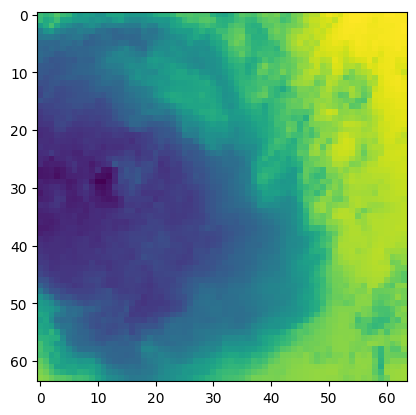

In [81]:
import matplotlib.pyplot as plt

plt.imshow(batch[0][0,2,0])

In [44]:
class MiniTrainer:
    "A mini trainer for the diffusion process"
    def __init__(self, 
                 train_dataloader, 
                 valid_dataloader, 
                 model, 
                 sampler, 
                 device="cuda", 
                 loss_func=nn.MSELoss(), 
                 ):
        self.train_dataloader = train_dataloader
        self.valid_dataloader = valid_dataloader
        self.loss_func = loss_func
        self.psnr = PeakSignalNoiseRatio().to(device)
        self.ssim = StructuralSimilarityIndexMeasure().to(device)
        self.model = model.to(device)
        self.scaler = torch.cuda.amp.GradScaler()
        self.device = device
        self.sampler = sampler
        self.val_batch = next(iter(valid_dataloader))[0].to(device)  # grab a fixed batch to log predictions
    
    def train_step(self, loss):
        "Train for one step"
        self.optimizer.zero_grad()
        self.scaler.scale(loss).backward()
        self.scaler.step(self.optimizer)
        self.scaler.update()
        self.scheduler.step()

    def one_epoch(self, epoch=None):
        "Train for one epoch, log metrics and save model"
        self.model.train()
        pbar = progress_bar(self.train_dataloader, leave=False)
        for batch in pbar:
            frames, t, noise = to_device(batch, device=self.device)
            with torch.autocast("cuda"):
                predicted_noise = self.model(frames, t)
                loss = self.loss_func(noise, predicted_noise)
            self.train_step(loss)
            wandb.log({"train_mse": loss.item(),
                       "learning_rate": self.scheduler.get_last_lr()[0]})
            pbar.comment = f"epoch={epoch}, MSE={loss.item():2.3f}"

    def one_epoch_validation(self, epoch=None):
        "Validates on val set"
        pbar = progress_bar(self.valid_dataloader, leave=False)
        psnr_metric = 0
        mse_metric = 0
        ssmi_metric = 0
        for val_batch in pbar:
            frames = val_batch[0].to(self.device)
            samples = self.sampler(self.model, past_frames=frames[:,:-1]).to(self.device)
            target = frames[:,-1].unsqueeze(1)
            psnr_metric += self.psnr(samples, target).float().cpu()
            ssmi_metric += self.ssim(samples, target).float().cpu()
            mse_metric += self.loss_func(samples, target).float().cpu()
        psnr_metric = psnr_metric / len(self.valid_dataloader)
        ssmi_metric = ssmi_metric / len(self.valid_dataloader)
        mse_metric = mse_metric / len(self.valid_dataloader)
        wandb.log({"val_psnr": psnr_metric,
                   "val_ssmi": ssmi_metric,
                   "val_mse": mse_metric})

    def prepare(self, config):
        wandb.config.update(config)
        config.total_train_steps = config.epochs * len(self.train_dataloader)
        self.optimizer = AdamW(self.model.parameters(), lr=config.lr, eps=1e-5)
        self.scheduler = OneCycleLR(self.optimizer, max_lr=config.lr, total_steps=config.total_train_steps)

    def fit(self, config):
        self.prepare(config)
        self.val_batch = self.val_batch[:min(config.n_preds, 8)]  # log first 8 predictions
        for epoch in progress_bar(range(config.epochs), total=config.epochs, leave=True):
            self.one_epoch(epoch)
            if config.validate_epochs:
                self.one_epoch_validation(epoch)
            
            # log predictions
            if epoch % config.log_every_epoch == 0:
                samples = self.sampler(self.model, past_frames=self.val_batch[:,:-1])
                self.one_epoch_validation(epoch)
                log_images(self.val_batch, samples)

        save_model(self.model, config.model_name)


def set_seed(s, reproducible=False):
    "Set random seed for `random`, `torch`, and `numpy` (where available)"
    try: torch.manual_seed(s)
    except NameError: pass
    try: torch.cuda.manual_seed_all(s)
    except NameError: pass
    try: np.random.seed(s%(2**32-1))
    except NameError: pass
    random.seed(s)
    if reproducible:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

def to_device(t, device="cpu"):
    if isinstance(t, (tuple, list)):
        return [_t.to(device) for _t in t]
    elif isinstance(t, torch.Tensor):
        return t.to(device)
    else:
        raise("Not a Tensor or list of Tensors")


def ls(path: Path): 
    "Return files on Path, sorted"
    return sorted(list(path.iterdir()))


def parse_args(config):
    "A brute force way to parse arguments, it is probably not a good idea to use it"
    parser = argparse.ArgumentParser(description='Run training baseline')
    for k,v in config.__dict__.items():
        parser.add_argument('--'+k, type=type(v), default=v)
    args = vars(parser.parse_args())
    
    # update config with parsed args
    for k, v in args.items():
        setattr(config, k, v)

In [12]:
from pathlib import Path
from types import SimpleNamespace

import wandb
import torch
from torch.utils.data import DataLoader

# from cloud_diffusion.dataset import download_dataset, CloudDataset
#from cloud_diffusion.utils import NoisifyDataloader, MiniTrainer, set_seed, parse_args
#from cloud_diffusion.ddpm import noisify_ddpm, ddim_sampler
# from cloud_diffusion.models import UNet2D, get_unet_params


PROJECT_NAME = "cloud_diffusion"
DATASET_ARTIFACT = 'ai-industry/cloud_diffusion/SEVIR:v0'

config = SimpleNamespace(    
    epochs=50, # number of epochs
    model_name="unet_small", # model name to save [unet_small, unet_big]
    strategy="ddpm", # strategy to use ddpm
    noise_steps=1000, # number of noise steps on the diffusion process
    sampler_steps=333, # number of sampler steps on the diffusion process
    seed=42, # random seed
    batch_size=32, # batch size
    img_size=64, # image size
    device="cuda", # device
    num_workers=8, # number of workers for dataloader
    num_frames=4, # number of frames to use as input
    lr=5e-4, # learning rate
    validation_days=3, # number of days to use for validation
    log_every_epoch=5, # log every n epochs to wandb
    n_preds=8, # number of predictions to make
    validate_epochs=False # compute metrics at each epoch 
    )

def train_func(config):
    config.model_params = get_unet_params(config.model_name, config.num_frames)

    set_seed(config.seed)
    device = torch.device(config.device)

    # downlaod the dataset from the wandb.Artifact
    files = download_dataset(DATASET_ARTIFACT, PROJECT_NAME)
    # train_days, valid_days = files[:-config.validation_days], files[-config.validation_days:]
    train_ds = CloudDataset(files=files, num_frames=config.num_frames, img_size=config.img_size)
    # valid_ds = CloudDataset(files=files, num_frames=config.num_frames, img_size=config.img_size).shuffle()

    # DDPM dataloaders
    train_dataloader = NoisifyDataloader(train_ds, config.batch_size, shuffle=True, 
                                         noise_func=noisify_ddpm,  num_workers=config.num_workers)
    valid_dataloader = NoisifyDataloader(train_ds, config.batch_size, shuffle=False, 
                                          noise_func=noisify_ddpm,  num_workers=config.num_workers)

    # model setup
    model = UNet2DTemporalCondition(**config.model_params)

    # sampler
    sampler = ddim_sampler(steps=config.sampler_steps)

    # A simple training loop
    trainer = MiniTrainer(train_dataloader, valid_dataloader, model, sampler, device)
    trainer.fit(config)

In [13]:
with wandb.init(project=PROJECT_NAME, entity='ai-industry', config=config, tags=["ddpm", config.model_name]):
    train_func(config)

wandb: Currently logged in as: maidacundo (ai-industry). Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact SEVIR:v0, 2756.25MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:39.2


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 1>:2                                                                              │
│ in train_func:62                                                                                 │
│ in fit:110                                                                                       │
│ in one_epoch:73                                                                                  │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1501 in _call_impl            │
│                                                                                                  │
│   1498 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1499 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1500 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1501 │   │   │   return forward_call(*args, **kwargs)                                          │
│   1502 │   │   # Do not call functions when jit is used                                          │
│   1503 │   │   full_backward_hooks, non_full_backward_hooks = [], []                             │
│   1504 │   │   backward_pre_hooks = []                                                           │
│ in forward:89                                                                                    │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1501 in _call_impl            │
│                                                                                                  │
│   1498 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1499 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1500 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1501 │   │   │   return forward_call(*args, **kwargs)                                          │
│   1502 │   │   # Do not call functions when jit is used                                          │
│   1503 │   │   full_backward_hooks, non_full_backward_hooks = [], []                             │
│   1504 │   │   backward_pre_hooks = []                                                           │
│ in forward:159                                                                                   │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1501 in _call_impl            │
│                                                                                                  │
│   1498 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1499 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1500 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1501 │   │   │   return forward_call(*args, **kwargs)                                          │
│   1502 │   │   # Do not call functions when jit is used                                          │
│   1503 │   │   full_backward_hooks, non_full_backward_hooks = [], []                             │
│   1504 │   │   backward_pre_hooks = []                                                           │
│ in forward:57                                                                                    │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
RuntimeError: Tensors must have same number of dimensions: go